# Step1: Load Model

In [1]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEV_GPU = torch.device('cuda:0')
DEV_CPU= torch.device('cpu')

import requests
import torch
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"

device = 0 if torch.cuda.is_available() else -1  # -1 indicates CPU
model =  LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="cuda"
)

# Load the processor
processor = AutoProcessor.from_pretrained(model_id)

2025-05-24 01:21:50.578502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748064110.593680 1252524 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748064110.598359 1252524 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748064110.611921 1252524 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748064110.611937 1252524 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748064110.611940 1252524 computation_placer.cc:177] computation placer alr

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Step2: Assumption1 Visualization

In [2]:
for name, module in model.language_model.named_modules():
    if "25.self_attn.q_proj" in name:
        Q = module.weight.T
    if "25.self_attn.k_proj" in name:
        K = module.weight.T
    if "25.self_attn.v_proj" in name:
        V = module.weight.T
    if "25.self_attn.o_proj" in name:
        O = module.weight.T
    if "25.mlp.down_proj" in name:
        D =  module.weight.T
    if "25.mlp.up_proj" in name:
        U =  module.weight.T
    if "25.mlp.gate_proj" in name:
        G =  module.weight.T

In [3]:
V_tensor = V@V.T
O_tensor = O@O.T
D_tensor = D@D.T
U_tensor = U@U.T
G_tensor = G@G.T
QK_tensor = Q@K.T

## Step2.1 Q@K.T

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
 
QK_tensors = {}
for layer in range(32):
    for name, module in model.language_model.named_modules():
        if f"{layer}.self_attn.q_proj" in name:
            Q = module.weight.T
        if f"{layer}.self_attn.k_proj" in name:
            K = module.weight.T
            
    QK_tensors[layer] = (Q @ K.T)[:64, :64].detach().cpu().numpy()



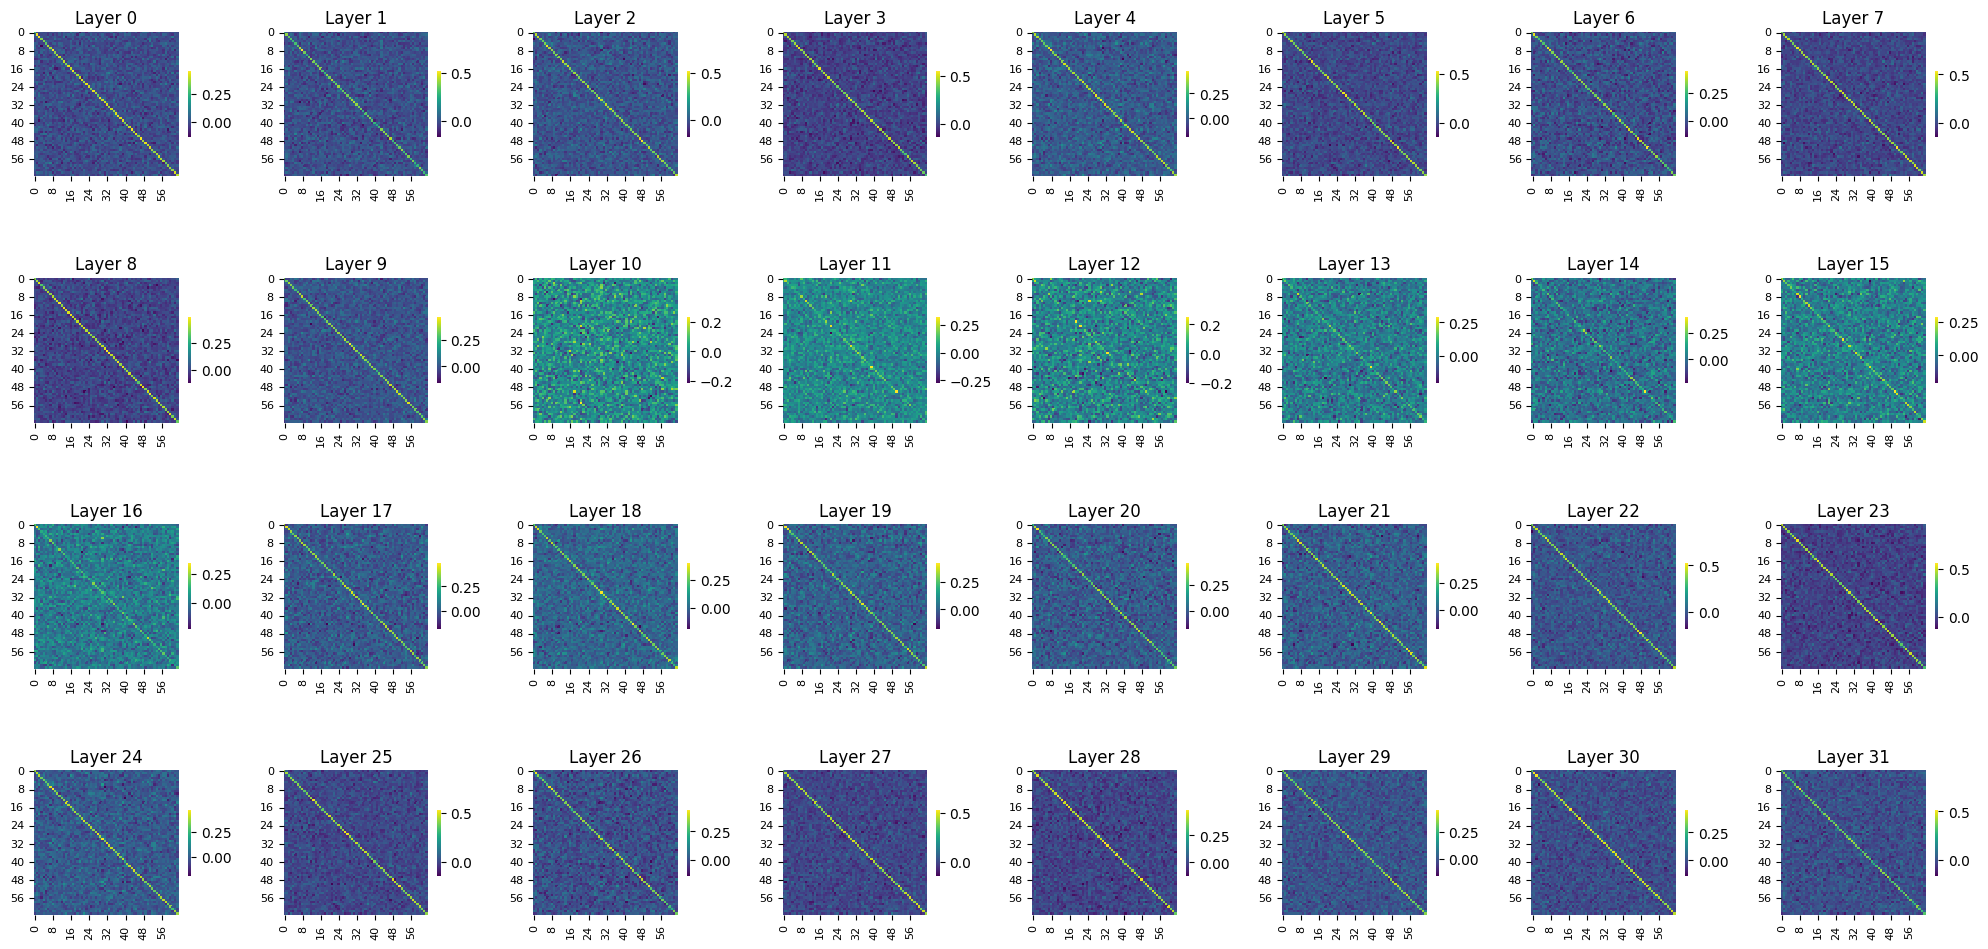

In [5]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < 32:
        sns.heatmap(QK_tensors[i], cmap='viridis', cbar=True, square=True, ax=ax, cbar_kws={'shrink': 0.3})
        ax.set_title(f'Layer {i}', fontsize=12)

        # 设置刻度
        ticks = np.arange(0, 64, 8)
        tick_labels = [str(t) for t in ticks]
        ax.set_xticks(ticks + 0.5)
        ax.set_yticks(ticks + 0.5)
        ax.set_xticklabels(tick_labels, fontsize=8)
        ax.set_yticklabels(tick_labels, fontsize=8)
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig('fig/QK_32_layers.pdf', bbox_inches='tight')
plt.show()


## Step2.1 O@O.T

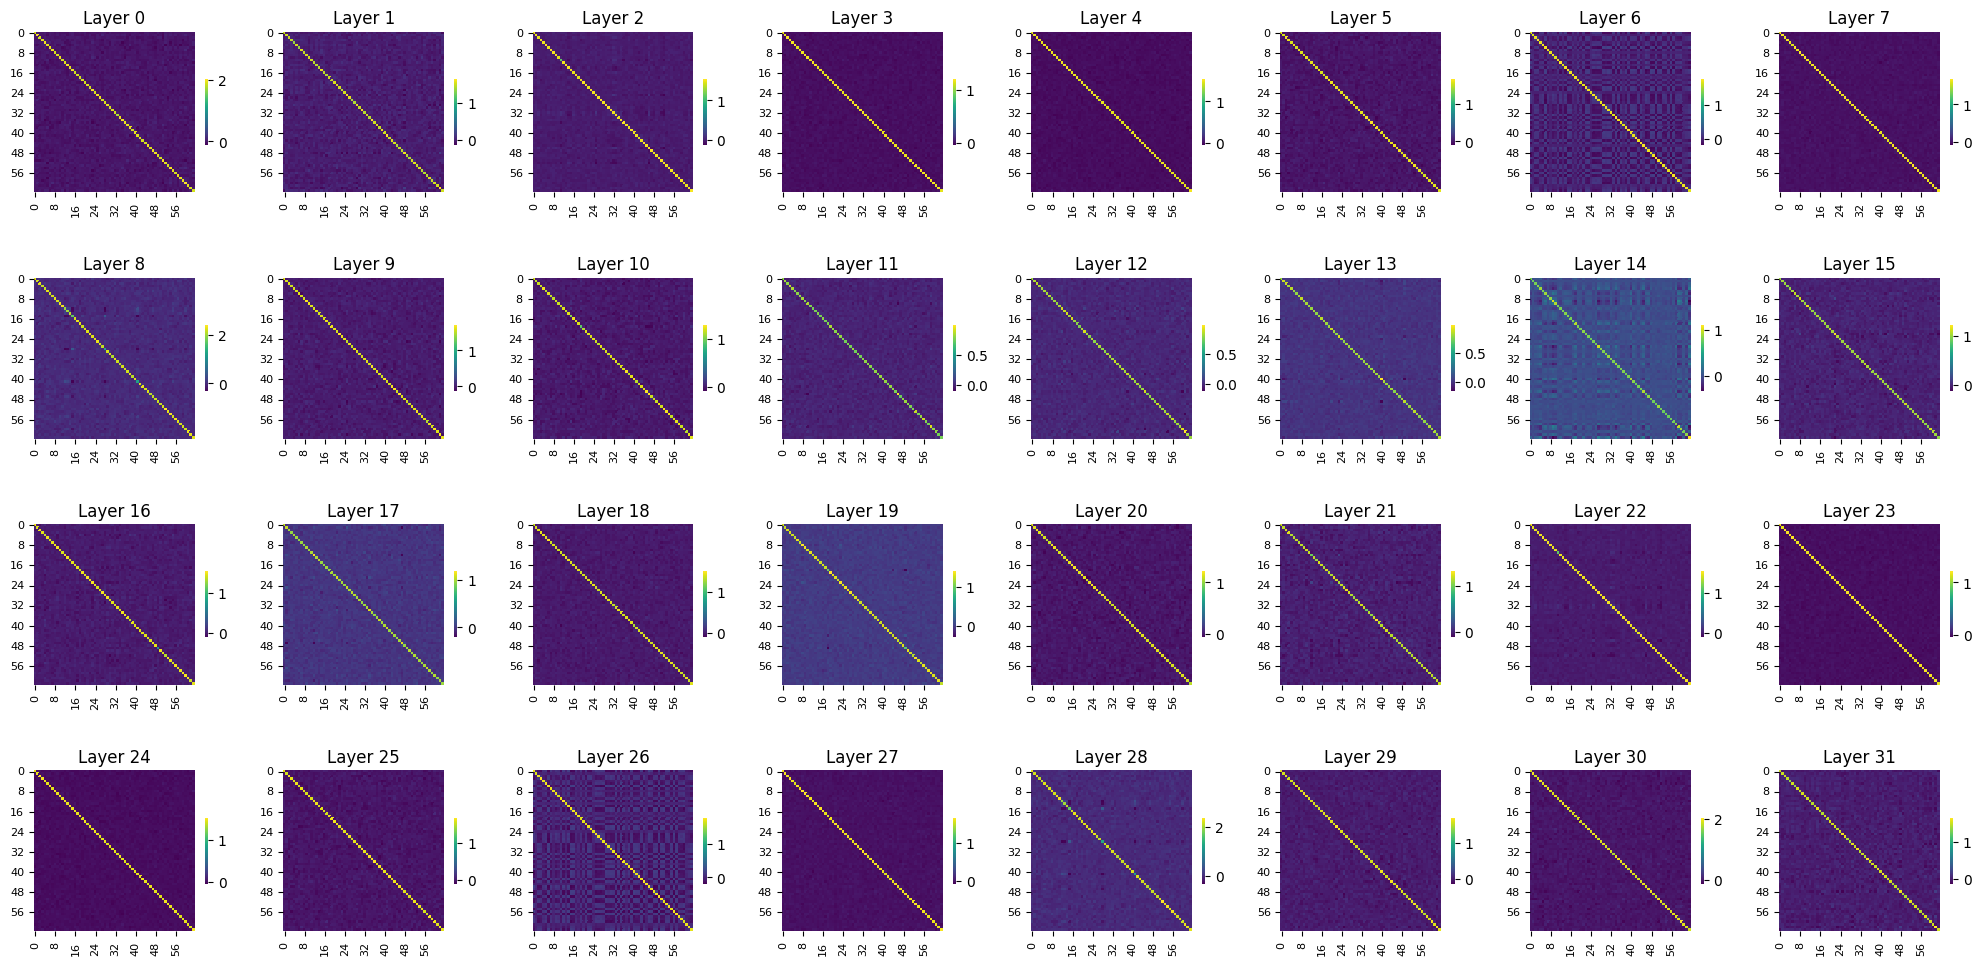

In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

O_tensors = {}
for layer in range(32):
    for name, module in model.language_model.named_modules():
        if f"{layer}.self_attn.o_proj" in name:
            O= module.weight.T
            O_tensors[layer] = (O @ O.T)[:64, :64].detach().cpu().numpy()


fig, axes = plt.subplots(4, 8, figsize=(20, 10)) 

for i, ax in enumerate(axes.flat):
    if i < 32:
        sns.heatmap(O_tensors[i], cmap='viridis', cbar=True, square=True, ax=ax, cbar_kws={'shrink': 0.3})
        ax.set_title(f'Layer {i}', fontsize=12)

        ticks = np.arange(0, 64, 8)
        tick_labels = [str(t) for t in ticks]
        ax.set_xticks(ticks + 0.5)
        ax.set_yticks(ticks + 0.5)
        ax.set_xticklabels(tick_labels, fontsize=8)
        ax.set_yticklabels(tick_labels, fontsize=8)
    else:
        ax.axis('off')


plt.tight_layout()
plt.savefig('fig/O_32_layers.pdf', bbox_inches='tight')
plt.show()

# Step3: Assumption2 Visualization

In [2]:
import torch
import re
model.cuda()
activation = []


def get_activation(name, activation_dict):
    def hook(model, input, output):
        activation_dict[name] = input[0].detach().to(DEV_CPU)
    return hook
 
def register_act_hooks(model, activation_dict):
    hooks = []
    for name, layer in model.language_model.named_modules():
        if "down_proj" in name:
            hooks.append(layer.register_forward_hook(get_activation(name, activation_dict)))
    return hooks


def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()


url     = ("https://huggingface.co/datasets/huggingface/"
           "documentation-images/resolve/"
           "0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg")
image   = Image.open(requests.get(url, stream=True).raw)
image = image.resize((256,256))
question = "What color clothes is the rabbit wearing?"

prompt = f"USER: <image>\n{question} ASSISTANT:"

inputs = processor(images=image,
                   text=prompt,
                   return_tensors="pt",
                   padding=True).to(0, torch.float16)

activation_dict = {}
hooks = register_act_hooks(model, activation_dict)

with torch.no_grad():
    outputs = model(**inputs)

activation.append(activation_dict)
remove_hooks(hooks)

In [3]:
import torch
act_atten_score=[]
for layer_num in range(32):
    str_act="model.layers."+str(layer_num)+".mlp.down_proj"
    tensor_A = activation[0][str_act].squeeze(0)
    
    binary_matrix = (tensor_A > 0.0).int()
    tensor_C = binary_matrix @ binary_matrix.T
    tensor_C = tensor_C.to(torch.int32)
    
    act_atten_score.append(tensor_C)

In [4]:
import torch
import torch.nn.functional as F
activation_out_sim=[]
actvation_out_degree=[]
for layer_num in range(32):
    str_act="model.layers."+str(layer_num)+".mlp.down_proj"
    tensor_A = activation[0][str_act].squeeze(0)
    
    A_last_row = tensor_A[-5, :].unsqueeze(0)
    cosine_similarities = F.cosine_similarity(tensor_A, A_last_row, dim=1)
    B = cosine_similarities    
    
    activation_out_sim.append(B)
    cosine_similarities_clamped = torch.clamp(cosine_similarities, -1.0, 1.0)
    angles_radians = torch.acos(cosine_similarities_clamped)
    angles_degrees = torch.rad2deg(angles_radians)
    actvation_out_degree.append(angles_degrees)


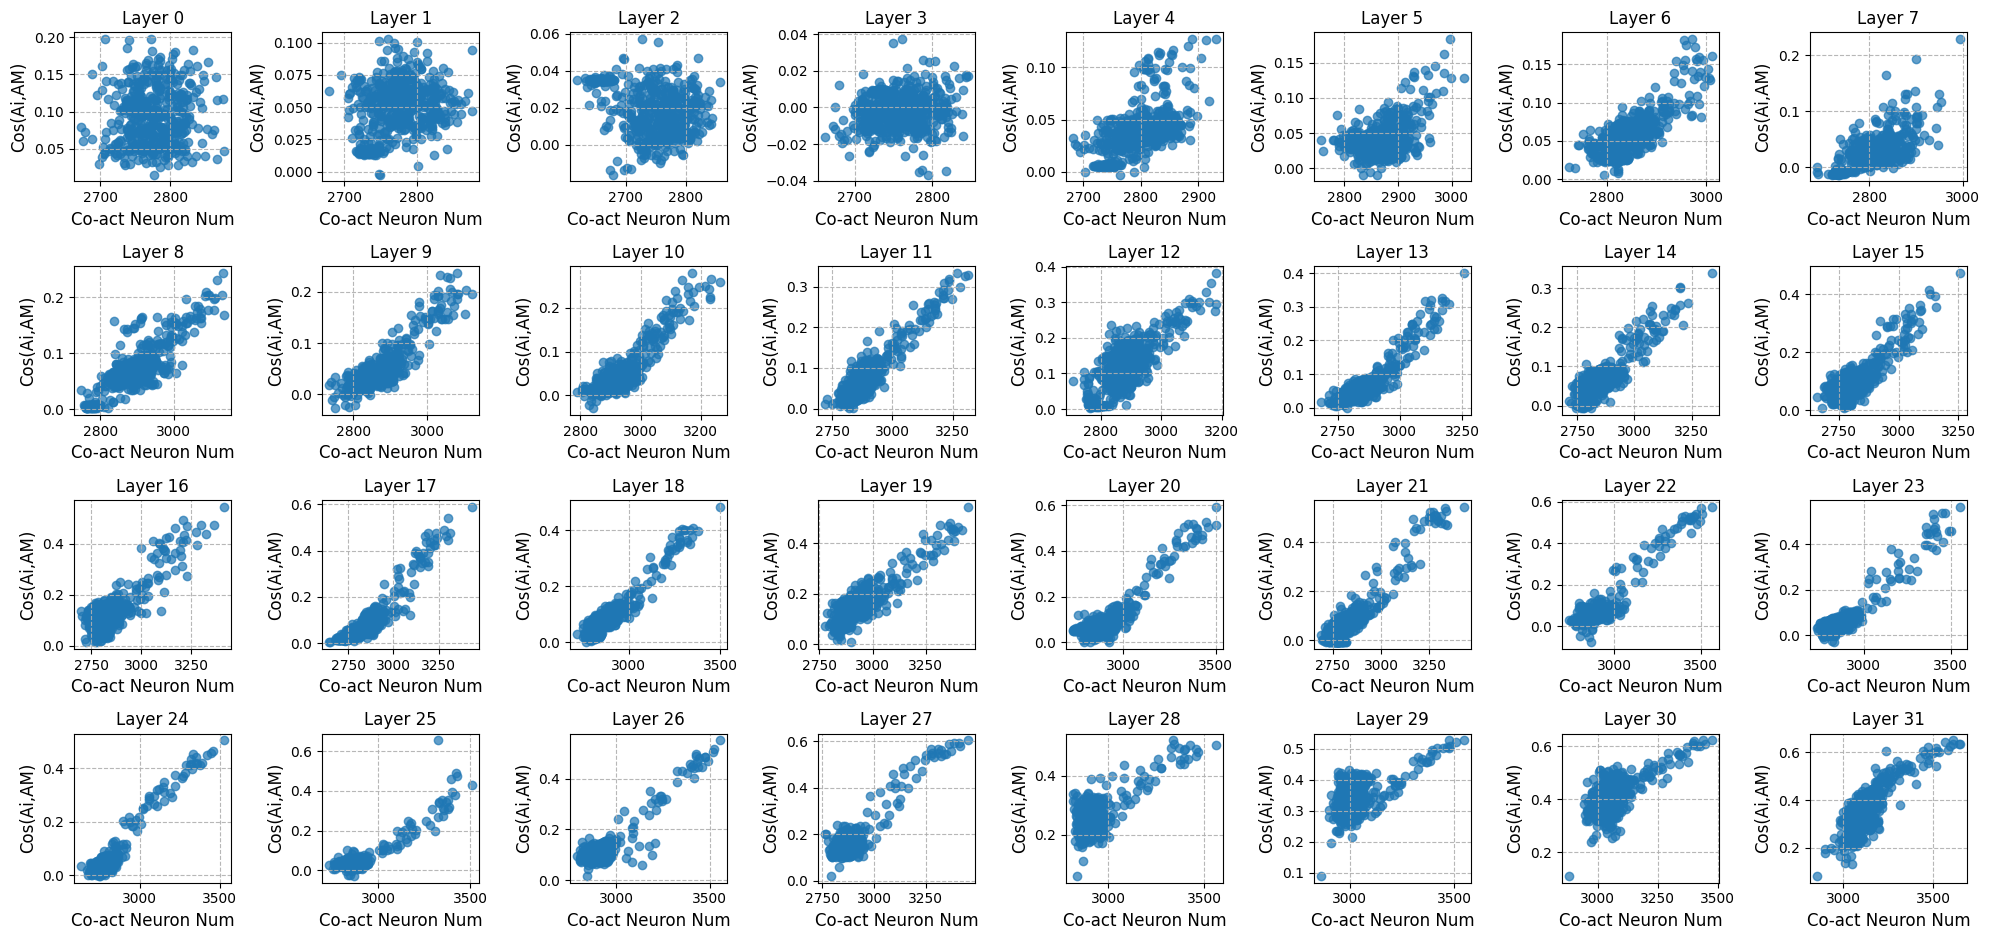

In [5]:
# Re-importing necessary libraries after environment reset
import matplotlib.pyplot as plt
import numpy as np

# Generate 32 sets of random data
num_plots = 32
rows, cols = 4, 8

# Initialize the canvas
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
# fig.suptitle("32 Scatter Plots (8 per row)", fontsize=16)

for i in range(num_plots):
    # Randomly generate data for each plot
    tensor_x = act_atten_score[i][-5][5:581].numpy() # 横坐标
    tensor_y = activation_out_sim[i][5:581].numpy() 
    
    # Get current subplot row and column indices
    row, col = divmod(i, cols)
    ax = axes[row, col]
    
    # Plot scatter plot
    ax.scatter(tensor_x, tensor_y, alpha=0.7)
    ax.set_title(f"Layer {i}", fontsize=12)
    ax.set_xlabel("Co-act Neuron Num", fontsize=12)
    ax.set_ylabel("Cos(Ai,AM)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.9)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('fig/cos_32.pdf', bbox_inches='tight')
plt.show()
